# Homework 4 - Group 1

## First task: House announcements

In this notebook we want to verify if the basic house informations reflect the house description.

First of all we imported all the libraries needed for this purpose.

In [1]:
import pickle
import pandas as pd
import numpy as np

import re
from bs4 import BeautifulSoup
import requests
import csv
import threading

import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from collections import Counter
from math import log

from sklearn.cluster import KMeans

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

import gmpy2
import sympy

### Web scrapping

In this first part we perfomed the web scrapping from the web page www.immobiliare.it.

We defined a function to get all the information needed.

In [2]:
def page_scrapping(web_link):
    
    source = requests.get(web_link).text
    soup = BeautifulSoup (source, 'lxml')
    info_matrix = []
    
    for announcement in soup.find_all('div', class_ = 'listing-item_body'):
        try:
            title = announcement.a.text
            price = announcement.li.text
        
            v=[]
            i=0
        
            for dati in announcement.find_all('div', class_ = 'lif__data'):
                a = dati.text
                v.append(a)
                i = i+1
            
            locali = v[0]
            superficie = v[1]
            bagni = v[2]
            piano = v[3]
        
            link =announcement.a['href']
            if link.find('https://www.immobiliare.it') == -1:
                link = 'https://www.immobiliare.it' + link
         
            source_desc = requests.get(link).text
            soup1 = BeautifulSoup (source_desc, 'lxml')
            description = soup1.find('div', class_ = 'description-text').text
       
            announce = [title, price, locali, superficie, bagni, piano, link, description]
        
            info_matrix.append(announce)
        except:
            continue
          
    return info_matrix
    

In [ ]:
A = page_scrapping('https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1')
matrix = np.array([np.array(xi) for xi in A])

In [ ]:
for i in range(2, 600):
    try:
        A = page_scrapping('https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=' + str(i))
        newMatrix = np.array([np.array(xi) for xi in A])
        print('Download' + str(i))
        matrix = np.concatenate((matrix, newMatrix), axis = 0)
    except:
        continue

Once we have all the data, we created a dataframe for them. And we save it in a pickle file.

In [ ]:
df= pd.DataFrame(matrix)
df.columns = ['Title', 'Price', 'Locali', 'Superficie', 'Bagni', 'Piano', 'Link', 'Description']
df.to_pickle('data_immobiliare')

In [3]:
df = pd.read_pickle("data_immobiliare")

### Text mining

Once we have our dataframe, we need to clean our data:

First we cleaned the informations as 'Price', 'Piano', 'Locali' in order to have all float numbers.

In [3]:
for i in range(len(df)):
    df.Price.loc[i] = re.sub('[€]', '' , df.Price.loc[i])
    df.Price.loc[i] = df.Price.loc[i].replace("PREZZO SU RICHIESTA", "0")
    df.Price.loc[i] = df['Price'].loc[i].split()[0]
    df.Price.loc[i] = df.Price.loc[i].replace(".", "")
    
    df.Piano.loc[i] = re.sub('T', '0', df.Piano.loc[i])
    df.Piano.loc[i] = re.sub('R', '0.5', df.Piano.loc[i])
    df.Piano.loc[i] = re.sub('A', '100', df.Piano.loc[i])
    df.Piano.loc[i] = re.sub('S', '-1', df.Piano.loc[i])
    df.Piano.loc[i] = re.sub(' \n', '', df.Piano.loc[i])
    df.Piano.loc[i] = df.Piano.loc[i].replace("11+", "11.5")
    
    
    df["Bagni"][i] = df["Bagni"][i].replace("+", ".5")
    
    df["Locali"][i] = df["Locali"][i].replace("+", ".5")
    
    df.replace(df.Superficie.loc[i], df.Superficie.loc[i].split()[0], inplace = True)

In [4]:
for i in range(len(df)):
    try:
        df.replace(df.Price.loc[i], float(df.Price.loc[i]), inplace = True)
        df.replace(df.Locali.loc[i], float(df.Locali.loc[i]), inplace = True)
        df.replace(df.Superficie.loc[i], float(df.Superficie.loc[i]), inplace = True)
        df.replace(df.Bagni.loc[i], float(df.Bagni.loc[i]), inplace = True)
        df.replace(df.Piano.loc[i], float(df.Piano.loc[i]), inplace = True)
        
    except:
        print('errore ' + str(i))
        continue

Then we can create two matrixes: one for the informations, and one for the description

In [5]:
df_info = df[['Price', 'Locali', 'Superficie', 'Bagni', 'Piano']].copy()
df_desc = df.filter(['Description'], axis=1)

df_info.to_pickle('df_info')
df_desc.to_pickle('df_desc')

In [4]:
df_info = pd.read_pickle("df_info")
df_desc = pd.read_pickle("df_desc")

We start to work on the description matrix: it's defined here a data cleaning function, used to clean all the reviews' texts and later on the queries.
A number of steps are performed for the task:
- replace $ with 'dollar', to avoid losing relevant information from the text
- replace new line symbols with whitespace
- remove puntuation
- separate numbers from words
- remove stopwords
- tokenize the text
- stem of the words, just keeping the root

In [5]:
def string_cleaning(string_raw):
    m = string_raw
    #removing website url
    m = re.sub('http.* *', '', string_raw, flags=re.MULTILINE)
    m = re.sub(r'\d+', '', string_raw)
    m = m.replace('\\r', ' ').replace('\\n', ' ')
    m = re.sub('[%s]' % re.escape(string.punctuation), ' ', m)
    m = re.sub('[%s]' % re.escape('“”€'), ' ', m)
    m = re.sub('[%s]' % re.escape('”'), ' ', m)
    m = re.sub(r'(?<=[\d+])(?=[a-zA-Z_])', r' ', m)
    m = nltk.tokenize.word_tokenize(m)
    m = [word for word in m if word.lower() not in stopwords.words('italian')]
    sno = nltk.stem.SnowballStemmer('italian')
    string_new = [sno.stem(word) for word in m]
    
    return string_new
            

Then we create a full corpus with all the words appeared in the descriptions

In [6]:
corpus = []
for i in range(len(df_desc)):
    corpus.append(df_desc.iloc[i][0])

For each word in the corpus it's performed the data cleaning and tokenization and the corpus has been flattened for the words' occurrence.

In [7]:
lista = []
for i in range(len(corpus)):
    lista.append(string_cleaning(corpus[i]))
    

lista_flatten = [y for x in lista for y in x]

The next step is to create a dictionary with all the words counted and then sorted by frequency.

In [8]:
c = Counter(lista_flatten)
c = dict(c.most_common())

final_dict = {str(i+1):x for i,x in enumerate(c)}
final_dict_inv = {str(x):(i+1) for i,x in enumerate(c)}

In the final_dict we assigned a number to each word, and the reverse in the final_dict_inv, that we are using to build the cosine similarity index.

In [9]:
indx = {}
for n,document in enumerate(lista):
    new_document = []
    for word in document:
        new_document.append(final_dict_inv[str(word)])
    indx[str(n+1)] = new_document 
    
inv_indx = {str(i):[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i in range(len(indx)):
        if int(word) in indx[str(i+1)]:
            inv_indx[word].append(i+1)

In the indx dictionary for each announce we reported the list of words that appear in it whit the correspondent number.

### Cosine similarity

To use the Cosine similarity it's needed to calcolate for each term:
- the frequency in each document: TF
- the IDF$_{i}$ defined has: $$IDF_{i}=\log{\frac{n}{N_{i}}}$$
where i is refered to term i

In [26]:
file_count= len(df_desc)

inv_indx_cosine = {i:[] for i in list(final_dict.keys())}
for word in list(final_dict.keys()):
    for i,l in enumerate(list(indx.values())):
        if int(word) in l:
            tf = l.count(int(word))/len(l)
            id_f = log(file_count/len(inv_indx[word]))
            inv_indx_cosine[word].append((i+1,tf*id_f))

In [ ]:
raws = len(indx) + 2
cols = len(inv_indx)
matrix = np.zeros((raws, cols))

We are able now to build a matrix with the announments on the raws and the words on the columns, were are recorded the tf-idf indexes.

In [ ]:
for i in range(len(indx)):
    for j in range(len(a[i])):
        col = int (a[i][j][0])
        print('i ' + str(i))
        print(j)
        print(col)
        
        matrix[i][col] = a[i][j][1]

In [ ]:
df_tfidf = pd.DataFrame(matrix)

We are saving that dataframe so we can use it later.

In [ ]:
df_tfidf.to_pickle('df_tfidf')

In [8]:
df_tfidf = pd.read_pickle("df_tfidf")

## Clustering

We are going to apply the K-means++ clustering to our info matrix first and than to the tf-idf matrix, related to the description.


In [9]:
kmeans_info = KMeans(n_clusters = 3).fit(df_info)

cls_info = dict()

for i in range(1, len(kmeans_info.labels_)):
    if kmeans_info.labels_[i] not in cls_info:
        cls_info[kmeans_info.labels_[i]] = [i]
    elif kmeans_info.labels_[i] in cls_info:
        cls_info[kmeans_info.labels_[i]].append(i)

In [10]:
kmeans_desc = KMeans(n_clusters = 6).fit(df_tfidf)

cls_desc = dict()

for i in range(1, len(kmeans_desc.labels_)):
    if kmeans_desc.labels_[i] not in cls_desc:
        cls_desc[kmeans_desc.labels_[i]] = [i]
    elif kmeans_desc.labels_[i] in cls_desc:
        cls_desc[kmeans_desc.labels_[i]].append(i)

Here it's defined a function to calculate the Jaccard-Similarity coefficient for each couple of clusters:

$ J(A,B) = \frac{A \cap B}{A \cup B} $

In [11]:
def jaccard(a, b):
   c = set(a).intersection(b)
   return float(len(c)) / (len(a) + len(b) - len(c))

So we calculate and store the Jaccard-Similarity coefficient and then we want to find the 3 maximum values between them.

In [12]:
A=[]
V = []
for i in range(6):
    v = []
    for j in range(3):
        jac = jaccard(cls_desc.get(i), cls_info.get(j))
        v.append(jac)
        V.append(jac)
    A.append(v)
    
b = list(reversed(sorted(V)))

In [13]:
rig = [0,0,0]
col = [0,0,0]
for i in range(6):
    for j in range(3):
        if A[i][j] == b[0]:
            rig[0] = i
            col[0] = j
        if A[i][j] == b[1]:
            rig[1] = i
            col[1] = j
        if A[i][j] == b[2]:
            rig[2] = i
            col[2] = j
        

In [32]:
couple_clustor = []
for i in range(3):
    a = set(cls_desc.get(rig[i])).intersection(cls_info.get(col[i]))
    b = list(set(a))[60:100]
    couple_clustor.append(b)

Now that we have the three more similar cluster we want to make a nice visualization of the most common words in them

We extract the descrpition from the clustors using description dataframe above and will create wordcloud.

We have to mask wordcloud to the image that I have downloaded as house. For this I will create a matrix mask.

In [25]:
house_mask = np.array(Image.open("house.png"))
house_mask[house_mask > 0] = 255

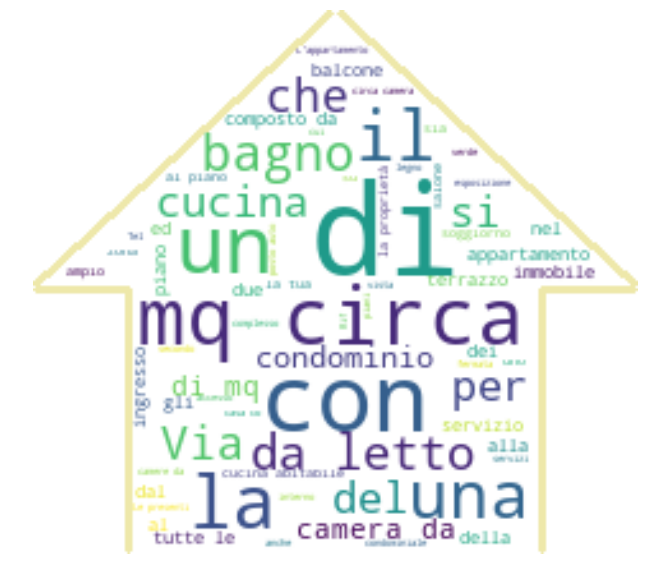

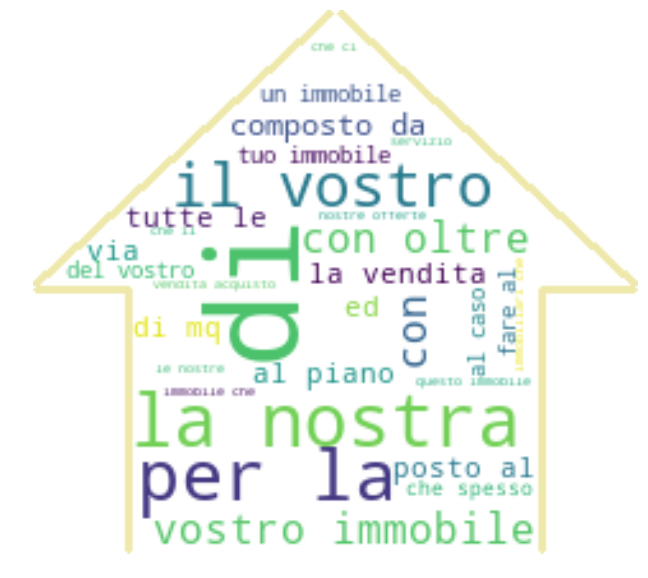

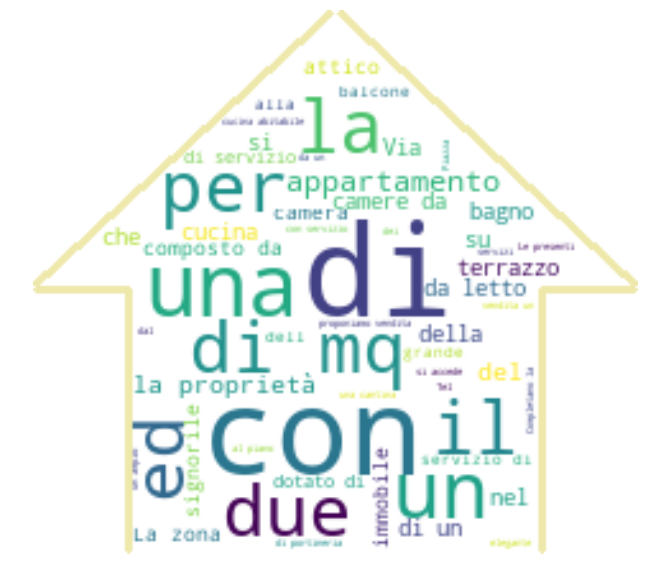

In [89]:
for i in range(3):
    descr = ""
    for item in couple_clustor[i]:
        description = ''.join(list(df.Description.loc[item])).replace("\n","").rstrip().lstrip()
        descr += description
    
      
    # Create and generate a word cloud image:
    wc = WordCloud(max_font_size=50, max_words=100, background_color="white", mask=house_mask,
                contour_width=3, contour_color='palegoldenrod')
    # Generate a wordcloud
    wc.generate(descr)
    # store to file
    wc.to_file("house_1.png")
    # show
    plt.figure(figsize=[20,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
  
        

## Second task: Find the duplicates!

For answering this question we have downloaded text [**passwords2.txt**](https://drive.google.com/open?id=1wTmOU-yqk4qdQYg42AquhzgpNGrRA96d). Then to answer the first part of the question we have to define a hash function to answer this questions. **Find duplicate strings**

But for the first part of this question we have to follow the definition of duplicates where order does not matter e.g  "AABA" = "AAAB" and "AAB"!= ABB

There are three steps we have follow. 
1. Convert the string containing the password to a (potentially large) number
2. Use a hash function to map the number to a large range. Read the class material and search the internet for this part (but you need to write the code yourself).
3. After having defined the hash function, find if two numbers fall on the same range

In [35]:
# use chunk size 9999999 lines
c_size = 9999999
txt_file = "passwords2.txt" #text file name

For simple comparison without considering order we really have to define very simple function as simple as it should be possible otherwise we will not have result as wanted. 

In [36]:
def simple_hash_function(passw, table_size):
    number = 0
    for character in passw: # getting each character of the password
        number += ord(character) # getting aschi of the character
    return number % table_size # returns the modular result

In [37]:
table_size_to_pass = 11 # should be prime for optimal result
first_string = "AABA" 
second_string ="AAAB"
first_value = simple_hash_function(first_string, table_size_to_pass)
second_value = simple_hash_function(second_string, table_size_to_pass)

In [38]:
[first_value,second_value]

[8, 8]

As you can see above it *first_value* and *second_value* are the same. 

#### In the file there are 10M duplicates, can you detect them?

To asnwer this question I have to read the file which is 2.2G which will take so much memory and of - course we can detect them but right now there is very high chance for getting collision we will resolve this problem in second part of the question where we consider the order as well. 

In [39]:
def open_file_return_passwords(file_name, number_of_lines = 10000, starting_index = 0, consider_size = True):
    i = 0
    p_items = []
    if(starting_index > 0):
        number_of_lines +=  starting_index
    c_size = number_of_lines
    for line in open(txt_file):
        if i == c_size and consider_size:
            break
        password = line.strip()
        if not starting_index > i:
            p_items.append(password)
        i += 1
    return p_items

Now we know how to read the file, lets move to answering the question detecting duplicate for this we need the Hash Table which size should be prime number for resolving performance issue. For the actual size as I am converting aschi characters to of 20 length passowrd. Each aschi-character length should not be greater than 127 as all the characters number is below this. 

In [40]:
table_size = ord('z') *20*31   # considering we have 20 character and I have multiplied it prim number so that 
table_size = sympy.nextprime(table_size) # getting next prim number from sympy library

In [41]:
hash_table =[] # we will use chaining technique for hash table values
passwords = open_file_return_passwords(txt_file, c_size)# open_file_and_return_passwords(txt_file, c_size)

for i in range(table_size):
    hash_table.append({}) # initializing table items
i = 0

for password in passwords:
    table_index = simple_hash_function(password, table_size)
    password = ''.join(sorted(password)) ## ignoring order of the password
    if password not in hash_table[table_index].keys():
        hash_table[table_index][password] = 0
    hash_table[table_index][password] = hash_table[table_index][password] + 1
    i = i+1

After running above code we have everything we need to answer the questions but ofcourse we are only considering first **9999999** lines of *passwords2.txt* file. Lets find duplicates first.  

In [42]:
#number of duplicates 
duplicates = 0 # this duplicate consider that we have total duplicate item adding both number of duplicates 
# which can be more than 1 
for item in hash_table:
    i = 0
    for key, value in item.items(): # dictionary item should have only one item otherwise they are false positive
        if(value > 1):
            duplicates += (value - 1) # removing 1 if only one count then that is not duplicate
duplicates

0

There are no duplicates in above **9999999** lines of the values. 

###### Does it happen that two strings with different characters are hashed to the same value? If yes, could you provide the number of False Positive?

Yes, it depends on size of the hash table. If size is less than number of passwords or anything that we are checking than there must be false positive. Lets find out how many false positive we have in our **9999999** of hash table size. 

In [43]:
table_size

75641

From above we have **75641** size of the table and we are using chaining technique so we can detect that by checking how many items are false positive. 

In [44]:
#number of duplicates 
false_positive = 0 # this duplicate consider that we have total duplicate item adding both number of duplicates 
# which can be more than 1 
for item in hash_table:
    i = 0
    if (len(item.items()) > 1):
        false_positive += (len(item.items()) - 1)  # removing 1 if only one count then that is not duplicate
false_positive

9999063

There are so many false positive values which says that our hash function sucks. :P Now the total false postive values are 9999063 which says that our function is almost 

In [45]:
c_size-false_positive

936

Only **936** times correct. 

Now lets move to define hash function. Here we are going to use the Multiplicative hash function. The two functions that works best and not too much complex are Multiplicative hash functions. Bernstein's function Kernighan and Ritchie's function. In which **Bernstein's function** uses *INITIAL_VALUE* of *5381* and *M* of *33*; **Kernighan and Ritchie's** function uses *INITIAL_VALUE* of 0 and *M* of 31. Here I am going to choose Bernstein's function. I am going to follow the **Bernstein's function**

In [46]:
def hash_function_with_weighting(password, table_size, INITIAL_VALUE = 5381, M = 33 ): 
    hash_value = INITIAL_VALUE;
    m = M
    for i in range(len(password)):
        hash_value =  m * hash_value + i * ord(password[i])
    return hash_value % table_size

Note that both *INITIAL_VALUE* and *M* is prime number. And we will consider the prime number as well for considering our *Hash Table* size or *array* size. 

Lets answer the first question that **find if two numbers fall on the same range*

In [47]:
table_size_to_pass = 11 # should be prime for optimal result
first_string = "AABA" 
second_string ="AAAB"
first_value = hash_function_with_weighting(first_string, table_size_to_pass)
second_value = hash_function_with_weighting(second_string, table_size_to_pass)

In [48]:
[first_value,second_value]

[8, 0]

As you can see that obove both strings are not equal. 

#### In the file there are 10M duplicates, can you detect them?

To answer this question now we also considering order now lets whether it will resolve issues with which we have so many false positives. We will also consider the same size of hash table. Lets see..

In [49]:
hash_table =[] # we will use chaining technique for hash table values
starting_index=99999999
passwords = open_file_return_passwords(txt_file, c_size,starting_index)# open_file_and_return_passwords(txt_file, c_size)

for i in range(table_size):
    hash_table.append({}) # initializing table items
i = 0

for password in passwords:
    table_index = hash_function_with_weighting(password, table_size)
    if password not in hash_table[table_index].keys():
        hash_table[table_index][password] = 0
    hash_table[table_index][password] = hash_table[table_index][password] + 1
    i = i+1

In [50]:
passwords[:3]

["8SyBU',YDgw*.ZAC#j4P", 'OHcv-/U3QI$rdqYTef"D', 'QtA*.xM$e(+"aO36r&Uo']

After running above code we have everything we need to answer the questions but ofcourse we are only considering first **9999999** lines of *passwords2.txt* file. Lets find duplicates first. But duplicates in first 99999999 lines is never going to be appear as it was before so I have sent starting index. 

In [51]:
#number of duplicates 
duplicates = 0 # this duplicate consider that we have total duplicate item adding both number of duplicates 
# which can be more than 1 
for item in hash_table:
    i = 0
    for key, value in item.items(): # dictionary item should have only one item otherwise they are false positive
        if(value > 1):
            duplicates += (value - 1) # removing 1 if only one count then that is not duplicate
duplicates

0

Still no duplicates in next **99999999** values. 

###### Does it happen that two strings with different characters are hashed to the same value? If yes, could you provide the number of False Positive?

Yes, it depends on size of the hash table. If size is less than number of passwords or anything that we are checking than there must be false positive. Lets find out how many false positive we have in our **9999999** of hash table size. 

In [52]:
table_size

75641

From above we have **75641** size of the table and we are using chaining technique so we can detect that by checking how many items are false positive. 

In [53]:
#number of duplicates 
false_positive = 0 # this duplicate consider that we have total duplicate item adding both number of duplicates 
# which can be more than 1 
for item in hash_table:
    i = 0
    if (len(item.items()) > 1):
        false_positive += (len(item.items()) - 1)  # removing 1 if only one count then that is not duplicate
false_positive

9924358

Now you can see that false positives are drastically decreased. 

In [54]:
c_size-false_positive

75641

Now our function is **75641** times correct.  

No hash function is perfect enough to lower the false positive. So the best approach for the hashing is to use different hash functions randomly to decreased the chance of the false positives. 